# Probabilistic classification

In this notebook we investigate different probabilistic metrics and scoring methods for classification tasks.

We have previously discussed the limitations of relying solely on accuracy as a metric, but when does this become particularly problematic? When should we consider utilizing probabilities instead of discrete predictions?

We will address these questions in this notebook.


## Accuracy paradox

We have previously highlighted the challenges associated with using accuracy as a metric, especially when dealing with imbalanced datasets. One classic example is evaluating the precision and recall of a medical test used to detect a disease within a population.

To avoid diving directly into coding with real-world data, let's begin by constructing a simple hypothetical scenario that demonstrates the accuracy paradox. This will help us understand the significance and implications of different scoring methods.

We will use `numpy` to generate sample data and test several metrics availble with `sklearn`.

We will use visualization libraries such as `seaborn` and `matplotlib` to provide visual representations of the concepts being explored.

In [1]:
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    log_loss,
    brier_score_loss,
)
import seaborn as sns
import matplotlib.pyplot as plt

Let's examine a disease characterized by two symptoms: a rash and a high temperature. Within our population of 10,000 individuals, we observe that 10% of the population has a rash, while 1% of the population exhibits a high temperature.

In [2]:
# Fix the random seed
np.random.seed(42)

# set probabilities
p_rash = 0.1
p_ht = 0.01

# create the population
rash = np.random.rand(10000) < p_rash
high_temp = np.random.rand(10000) < p_ht

In our hypothetical scenario, we have control over the proportions of individuals in different symptom categories who actually have the disease. We have those with a rash and a high temperature, those with a rash only, those with  a high temperature only, and those with no symptoms.

We consider a disease which affects:
* 90% of people with a rash **AND** a high temperature
* 2% of people with **ONLY** a rash
* 5% of people with **ONLY** a high temperature
* 0.1% of people showing **NO** symptoms.

In [3]:
both = rash * high_temp
rash_only = rash * np.invert(high_temp)
ht_only = np.invert(rash) * high_temp
neither = np.invert(rash * high_temp)

has_disease = np.bitwise_or(
    np.bitwise_or(
        np.bitwise_or(
            both * np.random.rand(10000) > 0.1, rash_only * np.random.rand(10000) > 0.98
        ),
        ht_only * np.random.rand(10000) > 0.95,
    ),
    neither * np.random.rand(10000) > 0.999,
)


We can easily check the number of people with diseases in the dataset.

In [4]:
sum(has_disease)

Our dataset exhibits significant class imbalance, with only approximately 0.05% of individuals actually having the disease. This makes it an excellent dataset for exploring the accuracy paradox and its implications.

Now, let's examine the accuracy of an overly simplistic classifier using the metrics module from scikit-learn.

In [5]:
simplistic_classifier = np.zeros(10000)

accuracy_score(has_disease, simplistic_classifier)

The classifier we're using assumes that all individuals do not have the disease. Since this holds true for over 99% of the population, if we solely rely on accuracy as a metric, the model would appear to perform well. However, this approach has clear design flaws that could lead us to mistakenly adopt it.

To gain a better understanding of the model and its limitations, we can examine its confusion matrix. The confusion matrix provides insights into the classifier's performance by presenting the counts of true positives, true negatives, false positives, and false negatives.

## Confusion matrix

To gain a clearer understanding of the classifier's performance, we can generate and visualize the confusion matrix for the `simplistic_classifier` and plot it as a heatmap using `sns.heatmap`. 

In [6]:
c_matrix = confusion_matrix(has_disease, simplistic_classifier)

plt.figure(figsize=(4, 4))
sns.heatmap(c_matrix, annot=False, fmt="d")
plt.tight_layout()

## Other discrete classifiers

Given that we have data on symptoms, we can now make assumptions about their relationship to the disease. We can utilize this information to build different models and compare their performance against each other.

In [7]:
print(
    "Silly classifier accuracy: {:.4f}".format(
        accuracy_score(has_disease, simplistic_classifier)
    )
)

print("Rash classifier accuracy: {:.4f}".format(accuracy_score(has_disease, rash)))

print("Temp classifier accuracy: {:.4f}".format(accuracy_score(has_disease, high_temp)))

print(
    "Both symptom classifier accuracy: {:.4f}".format(
        accuracy_score(has_disease, rash * high_temp)
    )
)

print(
    "Either symptom classifier accuracy: {:.4f}".format(
        accuracy_score(has_disease, rash + high_temp)
    )
)

The concept of accuracy, or accuracy score, as used in the above is defined as the fraction of total outcomes correctly predicted. This is equivalent to the fraction of the total values that fall along the diagonal of the confusion matrix.

While all of the alternative classifiers mentioned earlier are superior to the very silly classifier, they may differ in terms of their accuracy scores.

### Other discrete classification metrics

However, the choice of classifier depends on the *cost* associated with misclassification. To illustrate this, consider the following scenarios:

- If the disease is easily treatable, and the treatment does not harm individuals without the disease, false positives are not costly. In such cases, we would prefer a classifier with high *recall*.

- Conversely, if the disease is challenging to treat or the treatment has adverse effects on individuals without the disease, false positives become problematic. In such scenarios, we would prioritize a classifier with high *precision*.

These concepts are illustrated in the image below from [wikicommons](https://en.wikipedia.org/wiki/Precision_and_recall#/media/File:Precisionrecall.svg).

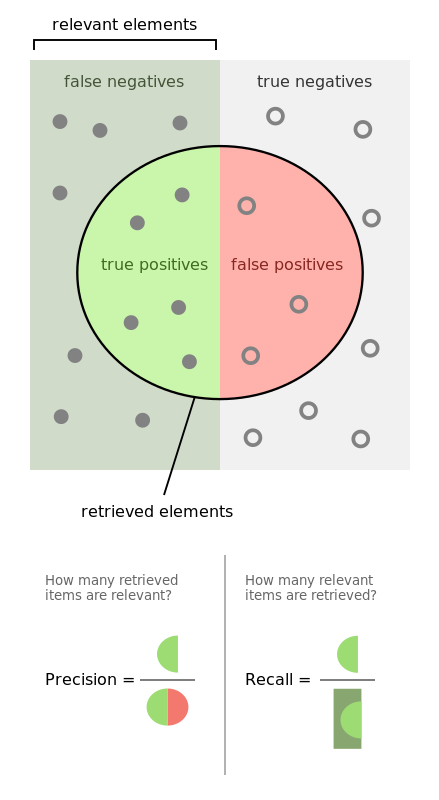

It is crucial to recognize that few patients would express anger toward a doctor or a medical AI if they were given an asthma inhaler for a mild cough. However, if someone's leg were amputated based on a misdiagnosis of gangrene, severe problems beyond the realm of machine learning would arise.

To address this inherent challenge in interpreting data through models, the `sklearn` library provides various metrics that can be utilized to ensure you aren't wrongfully amputating legs in a metaphorical sense.

We can investigate which classifiers perform best under different metrics.

In [8]:
metrics = {
    "precision": precision_score,
    "recall": recall_score,

    "f1": f1_score,

    "auroc": roc_auc_score,

}


clfs = {
    "Silly": simplistic_classifier,

    "Rash": rash,

    "Temp": high_temp,

    "Both symptom": rash * high_temp,

    "Either symptom": rash + high_temp,

}


for m_name, m in metrics.items():

    for clf_name, clf in clfs.items():

        print(
            "{} classifier {} score: {:.4f}".format(
                clf_name, m_name, m(has_disease, clf)
            )
        )

    print()

Once again, we can employ confusion matrices to gain a clearer understanding of each classifier's performance.

In [9]:
for clf_name, clf in clfs.items():
    plt.figure(figsize=(4, 4))
    c_matrix = confusion_matrix(has_disease, clf)
    sns.heatmap(c_matrix, annot=True, fmt="d")
    plt.tight_layout()
    plt.title(clf_name)

### We are data scientists, not doctors!
We have proposed five different classifiers, and determining the *best* among them relies on the specific metric used for evaluation.

One approach to assess their performance is by calculating the costs associated with misclassifications, such as false positives (diagnosing the disease when someone doesn't have it) and false negatives (failing to diagnose the disease when someone actually has it). However, this method necessitates prior knowledge of these costs.

The question arises: How can we develop generalized models that exhibit a strong fit and usefulness without without having to make these decisions?



## Probabilistic classification

The classifiers we have discussed so far are all examples of discrete classifiers. However, in practice, many classifiers are capable of generating class probabilities, including classifiers traditionally considered as non-probabilistic, such as SVM. In fact, certain classifiers, like logistic regression, inherently produce probabilities that need to be compared to a threshold to determine discrete class membership.

These classifiers, which generate probabilities, are referred to as *probabilistic classifiers.*

Let's consider some probabilistic classifiers for our hypothetical example. These classifiers will allow us to estimate the probabilities of individuals having the disease based on their symptoms.

## A probabilistic benchmark

Our first probabilistic classifier predicts the same probability for all our (in this case two) classes...

In [10]:
very_silly_probabilistic_classifier = 0.5 * np.ones(10000)

The above is silly because it just assumes the probability of having the disease is 50%. 

To establish a more effective benchmark classifier, we can examine the proportions of each class within our ground-truth data.

In [11]:
simple_probabilistic_classifier = (sum(has_disease) / len(has_disease)) * np.ones(10000)

Although considering the proportions of each class in the ground-truth data is a step forward as it incorporates population-level information, it still lacks individual-specific data to assign a probability of having the disease.

To construct a more refined classifier, we can take into account the symptoms exhibited by individuals. By incorporating this information, we can develop a better-performing classifier.

## Accounting for symptoms

By utilizing synthetic data, we gain control over the data generation process.

We can exploit use this to build the best possible probabilistic classifier - our data generation process itself!

In [12]:
p = 0.001 * np.ones(10000)
p[rash] = 0.02
p[high_temp] = 0.05
p[rash * high_temp] = 0.9
best_probabilistic_classifier = p

Now, we can provide the doctor (the client) with the probability of an individual having the disease. This enables them to make an informed decision on whether to proceed with treatment, as they have a clear understanding of the implications involved.

However, when it comes to scoring these classifiers, we cannot rely on accuracy alone, as it is based on predictions rather than probabilities.

There are two primary metrics that can be employed for both binary and multiclass cases:

### Binary

Let $y_i$ represent the ground-truth label for row $i$, where $y_i=0$ denotes the absence of the disease and $y_i=1$ indicates the presence of the disease. Let $N$ denote the total number of rows, and $P_i$ denote the predicted probability of an individual having the disease $(y_i=1)$.

The first metric is the *Brier score* (also known as Mean Squared Error or MSE), denoted as $BS$, given by:

$$ BS=\frac{1}{N}\sum_{i=1}^{N}(P_i - y_i)^2, $$

This score measures the squared difference between the assigned probabilities by the model and the actual probabilities in the real world. Hence, lower scores indicate better performance, while larger scores suggest poorer performance.

The second commonly used metric is the *Bernoulli log likelihood loss* (also known as cross-entropy loss), denoted as $L$, which is given by:

$$ L =-\frac{1}{N}\sum_{i=1}^{N}y_i*\ln(P_i) +(1-y_i)*\ln(1-P_i). $$

This metric is advantageous as it penalizes errors more significantly. It incorporates the logarithmic terms $\ln()$, which can become extremely large in extreme cases, making it sensitive to instances where the model assigns a near-1 probability to a person who is actually labeled as 0 in the data (and vice versa).

Both of these scores are considered losses, meaning that **smaller values indicate better performance**.

Let's use these metrics to analyse our probabilistic classifiers.

We can compute the log-loss and brier score for the probabilistic classifiers we proposed above.

In [13]:
prob_metrics = {"log-loss": log_loss, "brier": brier_score_loss}

prob_clfs = {
    "Silly": very_silly_probabilistic_classifier,
    "Simple": simple_probabilistic_classifier,
    "Advanced": best_probabilistic_classifier,
}

for m_name, m in prob_metrics.items():
    for clf_name, clf in prob_clfs.items():
        print(f"{clf_name} classifier {m_name} score: {m(has_disease, clf):.4f}")
    print()

### Multiclass

One of the reasons these metrics are widely used is their intuitive extension from single-class classification scenarios (e.g., having the disease or not) to cases involving multiple classes. Let's consider a scenario with $C$ classes. Here, we define $y_{i,c}$ as the ground truth label for row $i$ and class $c$, and $P_{i,c}$ as the predicted probability that $y_{i,c}=1$.

The multiclass Brier score is given by:

$$ BS=\frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C}(P_{i,c} - y_{i,c})^2. $$

The multinomial log-loss (no longer Bernoulli!) is given by:

$$ L =-\frac{1}{N}\sum_{i=1}^{N}\sum_{c=1}^{C}y_{i,c}*\ln(P_{i,c}). $$


#### Which probability metric to use?

Both of these metrics are commonly used in practice as they are considered *proper* scoring rules and can be differentiated for gradient-based descent, which is important for training models like neural networks and gradient-boosted trees.

The primary difference between the two is how they are bounded. The Brier-score is 0-1 bounded, with 0 for perfect predictions, and 1 for predictions which are completely wrong. However, the log-loss is 0-infinite bounded, again is 0 for perfect predictions, and is infinite if a single prediction is completely wrong.

This discrepancy arises from how we handle incorrect "certain" classifications, such as predicting a 0 for an event that actually occurred or a 1 for an event that did not. In these cases the log-likelihood becomes infinite (as $\ln(0)$ is infinite), whereas the BS score only increases by $\frac{1}{N}$.

The log-loss has a particular advantage when training and optimising a model - minimising the log-loss is equivalent to maximising the probability of the data given the model, and as such is know as Maximum Likelihood Estimation (MLE). Consequently, **we will be using the log-loss** as our primary metric today.

### Deciding on the Approach

* In general, the choice of method depends on the specific context and the potential impact of the individual classifications made by the tool. If the tool is intended for deployment in high-cost impact scenarios, such as medical condition classifications, it is often beneficial to have a human expert, such as a doctor, involved in the decision-making process. In this case, providing a probability distribution as an output can assist the expert in their decision-making. They can use the probabilities to guide further tests, gather additional data, or make a diagnosis and prescribe treatment accordingly.

* On the other hand, if the decisions to be made are low-cost, such as determining which advert to play next on a video streaming service, a deterministic classifier might be more appropriate. In such cases, the classifier can directly determine the best course of action without the need for probabilistic outputs.

* However, even with a probabilistic classifier, there are still deployment possibilities. For instance, in the case of judging the likelihood of a web user responding to different advertisements, one could arrange a sequence of ads based on decreasing likelihood. Alternatively, one could incorporate user response data to update the probabilities over time, or leverage assumptions about the real-world context alongside the classifier to make predictions. For example, if a user is known to be interested in sandwiches, advertising just before lunchtime may yield better results.

* Probabilistic models also have applications in simulations. Although they may not generally outperform well-designed deterministic classifiers in terms of accuracy or confusion matrix, simulations can provide valuable insights and capabilities. However, these advanced applications will be discussed later in the course.